# Laboratorium 2 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab2`
 * zainstaluj potrzebne biblioteki:
 `pip3 install matplotlib tabulate`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [1]:
# importujemy wszystkie potrzebne pakiety

from copy import copy
from itertools import product
from math import log, sqrt
from tabulate import tabulate
from random import betavariate, normalvariate, random, sample, shuffle, uniform
from bandit_framework import * # pakiet ze srodowiskiem testowym

In [2]:
# inicjalizujemy parametry testu

runs = 50
epochs = 100
recommendation_size = 10

In [3]:
# inicjalizujemy ramiona bandytow - payout kazdego ramienia bedzie reprezentowany przez rozklad normalny
#   te ramiona dobrze reprezentują CTR, czyli funkcje celu o rozkladzie Bernoulliego
#   - mamy prawdopodobienstwo aktywacji (klikniecia) p i staly payout po kliknieciu
# Mozemy takze przygotowac inne typy ramion, np. z payoutem losowanym z rozkladu normalnego lub wykladniczego

good_arms = [Arm(f'good_{i}', uniform(0.5, 0.7), lambda: 1) for i in range(10)]
bad_arms = [Arm(f'bad_{i}', uniform(0.1, 0.4), lambda: 1) for i in range(90)]
arms = {arm.arm_id: arm for arm in sample(good_arms+bad_arms, 100)}
arm_ids = list(arms.keys())

In [4]:
expected_highest_payout_per_epoch = sum(sorted([arm.activation_probability for arm in arms.values()], reverse=True)[:10])
print(f'Expected highest average payout per epoch: {expected_highest_payout_per_epoch}')

Expected highest average payout per epoch: 5.79898510058678


In [5]:
# pierwszy bandyta - wybiera losowe ramiona

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        return sample(self.arm_ids, size)
    
    def feedback(self, arm_id, payout):
        pass

In [6]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najelpsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, zeby metoda brute-force znalexc wartosc oczekiwana
        return sum([payout_function() for i in range(n)]) / n

In [7]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [8]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 582.1999999999998
random: 282.72


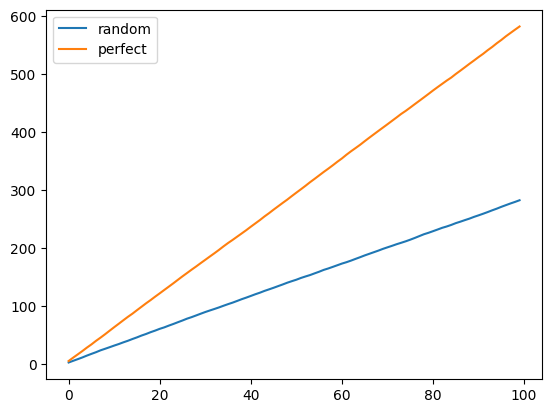

In [9]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 5.56
random: 2.88


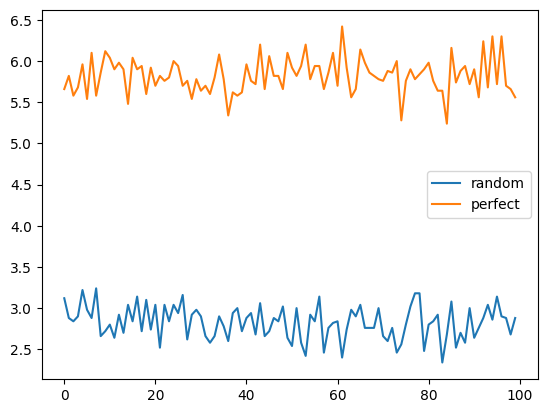

In [10]:
# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [11]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}

    def recommend(self, size):
        sorted_recommendations = sorted(self.payouts_per_recommendation, reverse=True)[:size]
        random_recommendations = sample(self.arm_ids, size)
        recommendations = []

        for i in range(size):
            if random() > self.epsilon:
                candidate = sorted_recommendations[i]
            else:
                candidate = random_recommendations[i]

            if candidate not in recommendations:
                recommendations.append(candidate)
                self.recommended_rates[candidate] += 1

        return recommendations

    def feedback(self, arm_id, payout):
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

In [12]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
        self.n = 0
    
    def recommend(self, size):
        self.n += size
        payout_plus_optimism = {}

        for arm in self.arm_ids:
            if self.recommended_rates[arm] == 0:
                payout_plus_optimism[arm] = float('inf')
            else:
                payout_plus_optimism[arm] = self.payouts_per_recommendation[arm] + self._optimism(arm)

        result = [arm_id for arm_id, _ in sorted(payout_plus_optimism.items(), key=lambda x: x[1], reverse=True)[:size]]

        for arm_id in result:
            self.recommended_rates[arm_id] += 1

        return result
    
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1

        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

    def _optimism(self, arm):
        if self.recommended_rates[arm] == 0:
            return float('inf')
        
        return self.optimism_weight * sqrt((2 * log(self.n)) / self.recommended_rates[arm])

In [13]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}
    
    def recommend(self, size):
        payout = {arm_id: betavariate(self.a[arm_id], self.b[arm_id]) for arm_id in arm_ids}
        recommended = [arm_id for arm_id, _ in sorted(payout.items(), key=lambda x: x[1], reverse=True)[:size]]

        return recommended
    
    def feedback(self, arm_id, payout):
        self.a[arm_id] += self.reward_multiplier * payout
        self.b[arm_id] += self.regret_multiplier * max(0, 1 - payout)

## Część 3. - zgrubne porównanie bandytów

In [14]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in product([1, 5, 10, 20, 50], [1, 5, 10, 20, 50])])

In [15]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_1_5
Simulating: ts_1_10
Simulating: ts_1_20
Simulating: ts_1_50
Simulating: ts_5_1
Simulating: ts_5_5
Simulating: ts_5_10
Simulating: ts_5_20
Simulating: ts_5_50
Simulating: ts_10_1
Simulating: ts_10_5
Simulating: ts_10_10
Simulating: ts_10_20
Simulating: ts_10_50
Simulating: ts_20_1
Simulating: ts_20_5
Simulating: ts_20_10
Simulating: ts_20_20
Simulating: ts_20_50
Simulating: ts_50_1
Simulating: ts_50_5
Simulating: ts_50_10
Simulating: ts_50_20
Simulating: ts_50_50



Aggregated results:

ts_1_20: 6.02
ts_10_20: 5.82
perfect: 5.78
ts_10_1: 5.78
ts_20_1: 5.76
ts_1_5: 5.72
ts_1_10: 5.72
egreedy_0.01: 5.68
ts_20_5: 5.66
ts_5_1: 5.64
ts_5_20: 5.56
ts_1_1: 5.54
egreedy_0.05: 5.52
ts_5_10: 5.52
ts_50_50: 5.52
egreedy_0.1: 5.5
ts_1_50: 5.5
ts_10_5: 5.38
ts_50_1: 5.38
ts_5_5: 5.34
ucb_0.1: 5.28
ts_10_10: 5.26
ucb_1: 5.16
ts_50_5: 5.14
ts_20_10: 5.1
ts_5_50: 5.08
ts_10_50: 5.06
ts_20_20: 5.02
ts_20_50: 4.96
egreedy_0.25: 4.92
ucb_0.01: 4.72
ts_50_20: 4.58
ts_50_10: 4.18
ucb_10: 3.24
random: 2.58


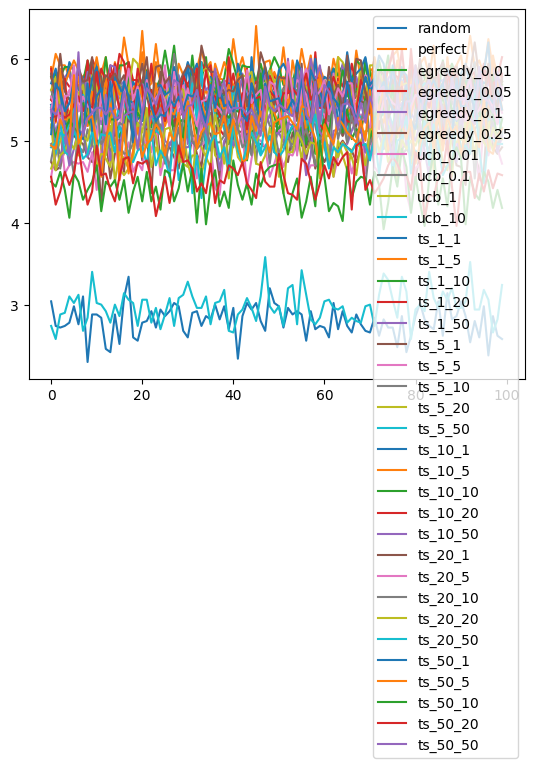

In [16]:
runner.plot_results(results, runs, epochs, mode='average')


Aggregated results:

perfect: 582.3599999999998
egreedy_0.01: 575.3000000000002
ts_20_1: 569.3399999999998
ts_1_5: 567.4999999999997
ts_10_1: 565.4600000000003
ts_1_1: 562.2600000000002
ts_1_20: 561.3800000000001
ts_5_20: 559.6
egreedy_0.05: 559.56
ts_1_50: 558.1
ts_10_20: 549.7800000000002
ts_1_10: 548.48
ts_5_5: 548.32
ts_20_5: 546.5799999999999
ts_50_1: 546.56
egreedy_0.1: 546.1600000000002
ts_5_10: 546.0200000000001
ts_5_1: 545.8600000000001
ts_10_5: 543.6600000000002
ts_50_50: 542.6800000000001
ts_5_50: 533.7199999999998
ts_10_10: 525.74
ucb_0.1: 512.04
ts_50_5: 510.0
ts_10_50: 507.9600000000001
ts_20_10: 506.02000000000004
ucb_1: 499.3400000000001
ts_20_20: 493.84
ts_20_50: 492.90000000000003
egreedy_0.25: 491.56000000000006
ucb_0.01: 483.5599999999998
ts_50_20: 454.90000000000015
ts_50_10: 442.44
ucb_10: 298.82000000000005
random: 280.0


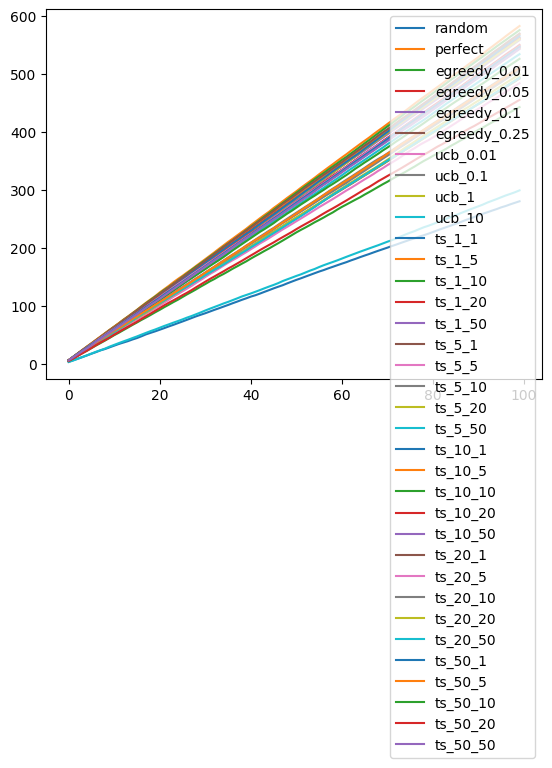

In [17]:
runner.plot_results(results, runs, epochs, mode='cumulative')

## Część 4. - dokładne porównanie bandytów

In [18]:
# obliczmy liste wszystkich dobrych ramion (arm_id zaczyna sie od 'good_') w rekomendacji
def relevant(recommendation: List[Arm]) -> int:
    return len([arm for arm in recommendation if arm.arm_id.startswith('good')])

all_relevant = relevant(arms.values())

In [19]:
# obliczmy precision@k i recall@k (na bazie funkcji relevant())
def precision_at_k(recommendation: List[Arm], k: int) -> float:
    if k == 0:
        return 0.0
    
    top_k = recommendation[:k]
    relevant_in_top_k = len([arm for arm in top_k if arm.arm_id.startswith('good_')])

    return relevant_in_top_k / k

def recall_at_k(recommendation: List[Arm], k: int, all_relevant: int) -> float:
    if all_relevant == 0:
        return 0.0
    
    top_k = recommendation[:k]
    relevant_in_top_k = len([arm for arm in top_k if arm.arm_id.startswith('good_')])
    
    return relevant_in_top_k / all_relevant

In [20]:
# sprawdzmy, czy dziala
sample_bandit = bandits[-1]
k = 3
recommendation_ids = sample_bandit.recommend(recommendation_size)
recommendation = [arms[arm_id] for arm_id in recommendation_ids]
print(f'Precision@{k} for bandit {sample_bandit.bandit_id}: {precision_at_k(recommendation, k)}')
print(f'Recall@{k} for bandit {sample_bandit.bandit_id}: {recall_at_k(recommendation, k, all_relevant)}')

Precision@3 for bandit ts_50_50: 1.0
Recall@3 for bandit ts_50_50: 0.3


In [21]:
class TestEntry():
    def __init__(self, bandit_name: str, k: int, precision: float, recall: float):
        self.bandit_name = bandit_name
        self.k = k
        self.precision = precision
        self.recall = recall
    
    def tuple(self):
        return (self.bandit_name, self.k, self.precision, self.recall)


def print_test_results(entries: List[TestEntry]):
    data = sorted(sorted([e.tuple() for e in entries], key=lambda e: e[1]), key=lambda e: e[0])
    headers = ('bandit', 'k', 'precision@k', 'recall@k')
    print(tabulate(data, headers, tablefmt='github'))

In [22]:
# wybieramy kilku istniejacych, wytrenowanych bandytow (perfect, random, po jednym e-greedy, UCB, TS)
tesing_bandits = [
    next(b for b in bandits if b.bandit_id == 'perfect'),
    next(b for b in bandits if b.bandit_id == 'random'),
    next(b for b in bandits if b.bandit_id == 'egreedy_0.1'),
    next(b for b in bandits if b.bandit_id == 'ucb_1'),
    next(b for b in bandits if b.bandit_id == 'ts_10_10'),
]
# wybieramy wartosci k do porownania
k_vals = [3, 5, 10]
# bedziemy liczyc sredni precision i recall dla `samples` rekomendacji
samples = 10
# miejsce na wyniki
results = []

# dla kazdego bandyty - generujemy `samples` rekomendacji, liczymy precision i recall, zapisujemy srednie wartosci
# powtarzamy dla kazdego k

# uwaga! przed przeprowadzeniem porownania, bandyci musza sie nauczyc
# pamietaj o uruchomieniu `runner.simulate()` w poprzedniej czesci

for bandit in tesing_bandits:
    for k in k_vals:
        precision_sum = 0.0
        recall_sum = 0.0

        for _ in range(samples):
            recommendation_ids = bandit.recommend(recommendation_size)
            recommendation = [arms[arm_id] for arm_id in recommendation_ids]

            precision_sum += precision_at_k(recommendation, k)
            recall_sum += recall_at_k(recommendation, k, all_relevant)

        avg_precision = precision_sum / samples
        avg_recall = recall_sum / samples

        results.append(TestEntry(bandit.bandit_id, k, avg_precision, avg_recall))

print_test_results(results)

| bandit      |   k |   precision@k |   recall@k |
|-------------|-----|---------------|------------|
| egreedy_0.1 |   3 |          0.9  |       0.27 |
| egreedy_0.1 |   5 |          0.86 |       0.43 |
| egreedy_0.1 |  10 |          0.91 |       0.91 |
| perfect     |   3 |          1    |       0.3  |
| perfect     |   5 |          1    |       0.5  |
| perfect     |  10 |          1    |       1    |
| random      |   3 |          0.2  |       0.06 |
| random      |   5 |          0.1  |       0.05 |
| random      |  10 |          0.11 |       0.11 |
| ts_10_10    |   3 |          1    |       0.3  |
| ts_10_10    |   5 |          1    |       0.5  |
| ts_10_10    |  10 |          0.8  |       0.8  |
| ucb_1       |   3 |          1    |       0.3  |
| ucb_1       |   5 |          1    |       0.5  |
| ucb_1       |  10 |          0.86 |       0.86 |
